In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, IFrame

# Pandas Tutor setup
%reload_ext pandas_tutor
%set_pandas_tutor_options {"maxDisplayCols": 8, "nohover": True, "projectorMode": True}

set_matplotlib_formats("svg")
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

def show_paradox_slides():
    src = 'https://docs.google.com/presentation/d/e/2PACX-1vSbFSaxaYZ0NcgrgqZLvjhkjX-5MQzAITWAsEFZHnix3j1c0qN8Vd1rogTAQP7F7Nf5r-JWExnGey7h/embed?start=false'
    width = 960
    height = 569
    display(IFrame(src, width, height))

# Lecture 4 – Simpson's Paradox, Joining, Transforming

## DSC 80, Fall 2023

## 📣 Announcements 📣

- Good job going to the right lecture room!
    - Discussion in Center 115.
- Lab 2 due Monday.
- Project 1 due next Wed.

## Clarification about `for` loops

- We've said that `for` loops are bad, and we should avoid them.
    - Then you had to use them a lot for Lab 1 and Project 1, what gives?
- Usually, using a `for` loop to iterate through individual values of a dataframe is slow.
    - Prefer to use filtering, grouping, etc.
    - But `for` loops are still the best way to iterate over Python values (e.g. a dictionary).
- **On assignments, we won't take off points for using `for` loops unless explicitly stated in the question.**

## Review: Distributions

In [2]:
penguins = sns.load_dataset('penguins').dropna()

### Joint distribution

When using `aggfunc='count'`, a pivot table describes the **joint distribution** of two categorical variables. This is also called a **contingency table**.

In [3]:
counts = penguins.pivot_table(
    index='species', 
    columns='sex', 
    values='body_mass_g', 
    aggfunc='count', 
    fill_value=0
)
counts

sex,Female,Male
species,,
Adelie,73,73
Chinstrap,34,34
Gentoo,58,61


### Discussion question:

Suppose we draw one penguin from `penguins` at random. Compute the following probabilities:

1. P(Adelie | Female)
1. P(Female | Adelie)
1. P(Male)
1. P(Chinstrap ⋂ Male)

In [4]:
counts

sex,Female,Male
species,,
Adelie,73,73
Chinstrap,34,34
Gentoo,58,61


In [5]:
# Compute your answers here

## Simpson's paradox

<center><img src="imgs/simpsons.png" width=50%></center>

### Example: Grades

- Two students, Lisa and Bart, just finished freshman year. They both took a different number of classes in Fall, Winter, and Spring.

- Each quarter, Lisa had a higher GPA than Bart.

- But Bart has a higher overall GPA.

- How is this possible? 🤔

Run this cell to create DataFrames that contain each students' grades.

In [6]:
lisa = pd.DataFrame([[20, 46], [18, 54], [5, 20]],
    columns=['Units', 'Grade Points Earned'], 
    index=['Fall', 'Winter', 'Spring'],
)

bart = pd.DataFrame([[5, 10], [5, 13.5], [22, 81.4]],
    columns=['Units', 'Grade Points Earned'], 
    index=['Fall', 'Winter', 'Spring'],
)

### Quarter-specific vs. overall GPAs

**Note:** The number of "grade points" earned for a course is

$$\text{number of units} \cdot \text{grade (out of 4)}$$

For instance, an A- in a 4 unit course earns $3.7 \cdot 4 = 14.8$ grade points.

In [7]:
lisa

,Units,Grade Points Earned
Fall,20,46
Winter,18,54
Spring,5,20


In [8]:
bart

,Units,Grade Points Earned
Fall,5,10.0
Winter,5,13.5
Spring,22,81.4


Lisa had a higher GPA in all three quarters:

In [9]:
quarterly_gpas = pd.DataFrame({
    "Lisa's Quarter GPA": lisa['Grade Points Earned'] / lisa['Units'],
    "Bart's Quarter GPA": bart['Grade Points Earned'] / bart['Units'],
})

quarterly_gpas

,Lisa's Quarter GPA,Bart's Quarter GPA
Fall,2.3,2.0
Winter,3.0,2.7
Spring,4.0,3.7


But Lisa's overall GPA was less than Bart's overall GPA:

In [10]:
tot = lisa.sum()
tot['Grade Points Earned'] / tot['Units']

2.7906976744186047

In [11]:
tot = bart.sum()
tot['Grade Points Earned'] / tot['Units']

3.278125

### What happened?

In [12]:
(quarterly_gpas
 .assign(Lisa_units=lisa['Units'],
         Bart_units=bart['Units']) 
 .iloc[:, [0, 2, 1, 3]]
)

,Lisa's Quarter GPA,Lisa_units,Bart's Quarter GPA,Bart_units
Fall,2.3,20,2.0,5
Winter,3.0,18,2.7,5
Spring,4.0,5,3.7,22


- When Lisa and Bart both performed poorly, Lisa took more units than Bart. **This brought down 📉 Lisa's overall average.**

- When Lisa and Bart both performed well, Bart took more units than Annie. **This brought up 📈 Bart's overall average.**

### Simpson's paradox

- Simpson's paradox occurs when **grouped data and ungrouped data show opposing trends**.
    - It is named after Edward H. Simpson, not Lisa or Bart Simpson.

- It is **purely arithmetic** – it is a consequence of weighted averages.

- It often happens because there is a hidden factor (i.e. a **confounder**) within the data that influences results.

- **Question:** What is the "correct" way to summarize your data? What if you had to act on these results?

### Example: How Berkeley was _almost_ sued for gender discrimination (1973)

What do you notice?

<center><img src='imgs/berkeley.png' width=70%></center>

In [13]:
show_paradox_slides()

### What happened?

- The overall acceptance rate for women (30%) was lower than it was for men (45%).

- However, most departments (A, B, D, F) had a higher acceptance rate for women.


- Department A had a 62% acceptance rate for men and an 82% acceptance rate for women!
    - 31% of men applied to Department A.
    - 6% of women applied to Department A.

- Department F had a 6% acceptance rate for men and a 7% acceptance rate for women!
    - 14% of men applied to Department F.
    - 19% of women applied to Department F.

- **Conclusion:** Women tended to apply to departments with a lower acceptance rate; the data don't support the hypothesis that there was major gender discrimination against women.

### Caution!

This doesn't mean that admissions are free from gender discrimination! 

From [Moss-Racusin et al., 2012, PNAS](https://www.pnas.org/doi/10.1073/pnas.1211286109) (cited 2600+ times):

> In a randomized double-blind study (n = 127), **science faculty** from research-intensive universities **rated the application materials of a student—who was randomly assigned either a male or female** name—for a laboratory manager position. Faculty **participants rated the male applicant as significantly more competent and hireable than the (identical) female applicant**. These participants also selected a higher starting salary and offered more career mentoring to the male applicant. The gender of the faculty participants did not affect responses, such that female and male faculty were equally likely to exhibit bias against the female student.

### But then...

From [Williams and Ceci, 2015, PNAS](https://www.pnas.org/doi/10.1073/pnas.1418878112):

> Here we report five hiring experiments in which faculty evaluated hypothetical female and male applicants, using systematically varied profiles disguising identical scholarship, for assistant professorships in biology, engineering, economics, and psychology. Contrary to prevailing assumptions, **men and women faculty members from all four fields preferred female applicants 2:1 over identically qualified males** with matching lifestyles (single, married, divorced), with the exception of male economists, who showed no gender preference.

### Do these conflict?

Not necessarily. One explanation, from William and Ceci:

> Instead, past studies have used ratings of students’ hirability for a range of posts that do not include tenure-track jobs, such as managing laboratories or performing math assignments for a company. However, hiring tenure-track faculty differs from hiring lower-level staff: it entails selecting among highly accomplished candidates, all of whom have completed Ph.D.s and amassed publications and strong letters of support. **Hiring bias may occur when applicants’ records are ambiguous, as was true in studies of hiring bias for lower-level staff posts, but such bias may not occur when records are clearly strong**, as is the case with tenure-track hiring.

### Do these conflict?

From Witteman, et al, 2019, in *The Lancet*:

> Thus, evidence of scientists favouring women comes exclusively from hypothetical scenarios, whereas evidence of scientists favouring men comes from hypothetical scenarios and real behaviour. This **might reflect academics' growing awareness of the social desirability of achieving gender balance, while real academic behaviour might not yet put such ideals into action**.

### Example: Restaurant reviews and phone types

* You are deciding whether to eat at Dirty Birds or The Loft.

* Suppose Yelp shows ratings aggregated by phone type (Android vs. iPhone).

|Phone Type|Stars for Dirty Birds|Stars for The Loft|
|---|---|---|
|Android|4.24|4.0|
|iPhone|2.99|2.79|
|**All**|**3.32**|**3.37**|


* **Question**: Should you choose Dirty Birds or The Loft? 
* **Answer**: The type of phone you use likely has nothing to do with your taste in food – pick the restaurant that is rated higher overall.
* Remember, Simpson's paradox is merely a property of weighted averages!

### Rule of thumb 👍

- Let $(X, Y)$ be a pair of variables of interest. Simpson's paradox happens when the association between $X$ and $Y$ reverses when we condition on $Z$, a third variable.
- If $Z$ has a **causal** connection to both $X$ and $Y$, we should condition on $Z$ and use deaggregated data.
- If not, we shouldn't condition on $Z$ and use the aggregated data instead.
- Berkeley gender discrimination: $X$ is gender, $Y$ is acceptance rate. $Z$ is the department.
    - $Z$ has a plausible causal effect on both $X$ and $Y$, so we should condition on $Z$.
- Yelp ratings: $X$ is the restaurant, $Y$ is the average stars. $Z$ is the phone type.
    - $Z$ doesn't plausibly cause $X$ to change, so we should not condition on $Z$.

### Takeaways

Be skeptical of...

- Aggregate statistics.
- People misusing statistics to "prove" that discrimination doesn't exist.
- Drawing conclusions from individual publications ($p$-hacking, publication bias, narrow focus, etc.).
- Everything!

**We need to apply domain knowledge and human judgement calls to decide what to do when Simpson's paradox is present.**

### Really?

To handle Simpson's paradox with rigor, we need some ideas from causal inference which we don't have time to cover in DSC 80. This video has a good example of how to approach Simpson's paradox using a minimal amount of causal inference, if you're curious (not required for DSC 80).

In [14]:
IFrame('https://www.youtube-nocookie.com/embed/zeuW1Z2EtLs?si=l2Dl7P-5RCq3ODpo',
       width=560, height=315)

### Further reading

- [Gender Bias in Admission Statistics?](https://www.cantorsparadise.com/gender-bias-in-admission-statistics-eaabca650810)
    - Contains a **great** visualization, but seems to be paywalled now.
- [What is Simpson's Paradox?](https://statisticsbyjim.com/basics/simpsons-paradox/) 
- [Understanding Simpson's Paradox](https://ftp.cs.ucla.edu/pub/stat_ser/r414.pdf): Requires more statistics background, gives rigorous understanding of when to use aggregated vs. unaggregated data.

## Merging

### Motivating Example: Name categories

NYT article about baby names (https://archive.is/NpORG) says that certain categories of names are becoming more popular. For example:

1. Forbidden names like Lucifer, Lilith, Kali, and Danger.
1. Evangelical names like Amen, Savior, Canaan, and Creed.
1. Mythological names
1. etc.

And also, baby boomer names are becoming less popular.

Let's see if we can verify these claims using data!

In [15]:
baby = pd.read_csv('data/baby.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
3,Oliver,M,15076,2022
...,...,...,...,...
2085154,Worthy,M,5,1880
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


In [17]:
nyt = pd.read_csv('data/nyt_names.csv')
nyt

,nyt_name,category
0,Lucifer,forbidden
1,Lilith,forbidden
2,Danger,forbidden
3,Amen,evangelical
...,...,...
19,Amethyst,mineral
20,Venus,celestial
21,Celestia,celestial
22,Skye,celestial


### Joining

- We want to link rows together whenever the names match up.
- This is a **join** (SQL term), i.e. a **merge** (`pandas` term).
- A join is appropriate when we have two sources of information **about the same individuals** that is **linked by a common column(s)**.
- The common column(s) are called the **join key**.

Let's demonstrate on a small subset of `baby` and `nyt`.

In [18]:
nyt_small = nyt.iloc[[11, 12, 14]].reset_index(drop=True)

names_to_keep = ['Julius', 'Karen', 'Noah']
baby_small = (baby
 .query("Year == 2020 and Name in @names_to_keep")
 .reset_index(drop=True)
)

In [19]:
nyt_small

,nyt_name,category
0,Karen,boomer
1,Julius,mythology
2,Freya,mythology


In [20]:
baby_small

,Name,Sex,Count,Year
0,Noah,M,18407,2020
1,Julius,M,966,2020
2,Karen,F,330,2020
3,Noah,F,306,2020
4,Karen,M,6,2020


### Let's do a join!

In [22]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name')

### The `merge` method

- The `merge` DataFrame method joins two tables by columns or indexes.
    - "Merge" is just the `pandas` word for "join".


- When using the `merge` method, the DataFrame before `.merge` is the "left" DataFrame, and the DataFrame passed into `.merge` is the "right" DataFrame.
    - In `baby_small.merge(nyt_small)`, `baby_small` is considered the "left" DataFrame and `nyt_small` is the "right" DataFrame; the columns from the left DataFrame appear to the left of the columns from right DataFrame.


- By default:
    - If join keys are not specified, all shared columns between the two DataFrames are used.
    - The "type" of join performed is an inner join.

### Join types: inner joins

- Note that `'Noah'` and `'Freya'` do not appear in the merged DataFrame.
- This is because there is:
    - no `'Noah'` in the right DataFrame, and
    - no `'Freya'` in the left DataFrame.
- The default type of join that `merge` performs is an **inner join**, which keeps the **intersection** of the join keys.


<center><img src='imgs/image_0.png' width=20%></center>

### Different join types

We can change the type of join performed by changing the `how` argument in `merge`. Let's experiment!

In [26]:
%%pt
# Note the NaNs!
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='left')

In [27]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='right')

In [28]:
%%pt
baby_small.merge(nyt_small, left_on='Name', right_on='nyt_name', how='outer')

### Different join types handle mismatches differently

There are four types of joins.

* **Inner:** keep **only** matching keys (intersection).
* **Outer:** keeps **all** keys in both DataFrames (union).
* **Left:** keep all keys in the left DataFrame, whether or not they are in the right DataFrame.
* **Right:** keep all keys in the right DataFrame, whether or not they are in the left DataFrame.
    * Note that `a.merge(b, how='left')` contains the same information as `b.merge(a, how='right')`, just in a different order.

<center><img src='imgs/image_1.png' width=30%></center>

### Notes on the `merge` method

- `.merge` is flexible, you can merge using a combination of columns, or the index of the dataframe.
-  If the two dataframes have the same column names, `pandas` will add `_x` and `_y` to the duplicated column names to avoid having columns with the same name (change with the `suffixes` argument).
- There is, in fact, a `.join` method, but it's actually a wrapper around `.merge` with fewer options.

## Many-to-one & many-to-many joins

### One-to-one joins

- So far in this lecture, the joins we have worked with are called **one-to-one** joins.
- Neither the left DataFrame nor the right DataFrame contained any duplicates in the join key.
- What if there are duplicated join keys, in one or both of the DataFrames we are merging?

In [35]:
# Run this cell to set up the next example.

profs = pd.DataFrame(
[['Sam', 'UCB', 5],
 ['Sam', 'UCSD', 5],
 ['Janine', 'UCSD', 8],
 ['Marina', 'UIC', 7],
 ['Justin', 'OSU', 5],
 ['Soohyun', 'UCSD', 2],
 ['Suraj', 'UCB', 2]],
    columns=['Name', 'School', 'Years']
)

schools = pd.DataFrame({
    'Abr': ['UCSD', 'UCLA', 'UCB', 'UIC'],
    'Full': ['University of California San Diego', 'University of California, Los Angeles', 'University of California, Berkeley', 'University of Illinois Chicago']
})

programs = pd.DataFrame({
    'uni': ['UCSD', 'UCSD', 'UCSD', 'UCB', 'OSU', 'OSU'],
    'dept': ['Math', 'HDSI', 'COGS', 'CS', 'Math', 'CS'],
    'grad_students': [205, 54, 281, 439, 304, 193]
})

### Many-to-one joins

- Many-to-one joins are joins where **one** of the DataFrames contains duplicate values in the join key. 
- The resulting DataFrame will preserve those duplicate entries as appropriate. 

In [36]:
profs

,Name,School,Years
0,Sam,UCB,5
1,Sam,UCSD,5
2,Janine,UCSD,8
3,Marina,UIC,7
4,Justin,OSU,5
5,Soohyun,UCSD,2
6,Suraj,UCB,2


In [37]:
schools

,Abr,Full
0,UCSD,University of California San Diego
1,UCLA,"University of California, Los Angeles"
2,UCB,"University of California, Berkeley"
3,UIC,University of Illinois Chicago


Note that when merging `profs` and `schools`, the information from `schools` is duplicated.
- `'University of California, San Diego'` appears three times.
- `'University of California, Berkeley'` appears twice.

In [38]:
# Why is a left merge most appropriate here?
profs.merge(schools, left_on='School', right_on='Abr', how='left')

,Name,School,Years,Abr,Full
0,Sam,UCB,5,UCB,"University of California, Berkeley"
1,Sam,UCSD,5,UCSD,University of California San Diego
2,Janine,UCSD,8,UCSD,University of California San Diego
3,Marina,UIC,7,UIC,University of Illinois Chicago
4,Justin,OSU,5,NaN,NaN
5,Soohyun,UCSD,2,UCSD,University of California San Diego
6,Suraj,UCB,2,UCB,"University of California, Berkeley"


### Many-to-many joins

Many-to-many joins are joins where both DataFrames have duplicate values in the join key.

In [39]:
profs

,Name,School,Years
0,Sam,UCB,5
1,Sam,UCSD,5
2,Janine,UCSD,8
3,Marina,UIC,7
4,Justin,OSU,5
5,Soohyun,UCSD,2
6,Suraj,UCB,2


In [40]:
programs

,uni,dept,grad_students
0,UCSD,Math,205
1,UCSD,HDSI,54
2,UCSD,COGS,281
3,UCB,CS,439
4,OSU,Math,304
5,OSU,CS,193


Before running the following cell, try predicting the number of rows in the output.

In [41]:
%%pt

profs.merge(programs, left_on='School', right_on='uni')

- `merge` stitched together every UCSD row in `profs` with every UCSD row in `programs`. 
- Since there were 3 UCSD rows in `profs` and 3 in `programs`, there are $3 \cdot 3 = 9$ UCSD rows in the output. The same applies for all other schools.

## Returning back to our original question

Let's find the popularity of baby name categories over time.

In [46]:
cate_counts = (
    baby
    .merge(nyt, left_on='Name', right_on='nyt_name')
    .groupby(['category', 'Year'])
    ['Count']
    .sum()
    .reset_index()
)
cate_counts

,category,Year,Count
0,boomer,1880,292
1,boomer,1881,298
2,boomer,1882,326
3,boomer,1883,322
...,...,...,...
658,mythology,2019,3330
659,mythology,2020,3516
660,mythology,2021,3895
661,mythology,2022,4049


In [53]:
# We'll talk about plotting code soon!
import plotly.express as px
fig = px.line(cate_counts, x='Year', y='Count',
              facet_col='category', facet_col_wrap=3,
              facet_row_spacing=0.15,
              width=600, height=400)
fig.update_yaxes(matches=None, showticklabels=False)

## Transforming

<img src="imgs/consonants.png" width=500 />

In [54]:
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
3,Oliver,M,15076,2022
...,...,...,...,...
2085154,Worthy,M,5,1880
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


### Transforming values

The most flexible method is `apply`: takes in a function that receives a single value as input, returns a single value.

In [58]:
def number_of_vowels(string):
    return sum(c in 'aeiou' for c in string.lower())

baby['Name'].apply(number_of_vowels)

0          2
1          2
2          4
3          3
          ..
2085154    1
2085155    1
2085156    1
2085157    4
Name: Name, Length: 2085158, dtype: int64

In [60]:
# Builtin functions work
baby['Name'].apply(len)

0          4
1          4
2          6
3          6
          ..
2085154    6
2085155    6
2085156    4
2085157    9
Name: Name, Length: 2085158, dtype: int64

### Looking at "L" names

<AxesSubplot:xlabel='Year'>

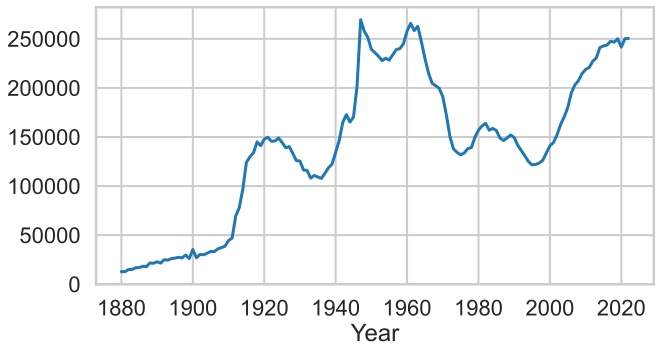

In [68]:
def first_letter(string):
    return string[0]

(baby
 .assign(first=baby['Name'].apply(first_letter))
 .query('first == "L"')
 .groupby('Year')
 ['Count']
 .sum()
 .plot()
)

### The Price of `.apply`

Actually, `.apply` runs really slowly!

In [72]:
%%timeit
baby['Name'].apply(first_letter)

151 ms ± 622 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit
res = []
for name in baby['Name']:
    res.append(name[0])

176 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Internally, `.apply` actually just runs a `for` loop.**

- So for arthimetic operations, definitely prefer working on Series objects directly!

### The Price of `.apply`

In [84]:
%%timeit
baby['Year'] // 10 * 10

4.87 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
%%timeit
baby['Year'].apply(lambda y: y // 10 * 10)

453 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**100x slower!**

### The `.str` accessor

For string operations, `pandas` provides a convenient `str` accessor.

In [87]:
# Equivalent to:
# baby['Name'].apply(first_letter)
baby['Name'].str[0]

0          L
1          N
2          O
3          O
          ..
2085154    W
2085155    W
2085156    Y
2085157    Z
Name: Name, Length: 2085158, dtype: object

In [92]:
baby['Name'].str.len()

0          4
1          4
2          6
3          6
          ..
2085154    6
2085155    6
2085156    4
2085157    9
Name: Name, Length: 2085158, dtype: int64

- Very convenient, but **runs even slower than `.apply`!**
- Even though it's slow, we use `.str` anyway because it makes life easier.

## Other Data Representations

- In DSC 80, we work with dataframes in `pandas`.
    - When we say `pandas` `DataFrame`, we're talking about the `pandas` API for its `DataFrame` objects.
    - When we say "dataframe", we're referring to a general way to represent data (rows, columns, labels for both rows and columns)
- Of course, many other way to work with data tables! R has a dataframe, SQL databases, spreadsheets, even matrices from linear algebra.
    - When you learn SQL in DSC 100, you'll find many similaries (e.g. slicing columns, filtering rows, grouping, joining, etc.)
    - **Relational algebra** captures common data operations between many data table systems.
- Why use dataframes over something else?

### Dataframes vs. Spreadsheets

- Dataframes gives us a data lineage: the code records down data changes. Not so in spreadsheets!
- Using a general-purpose programming language gives us the ability to handle much larger datasets, and we can using distributed computing systems to handle massive datasets.

### Dataframes vs. Matrices

\begin{split}
\begin{aligned}
\mathbf{X} = \begin{bmatrix}
1 & 0 \\
0 & 4 \\
0 & 0 \\
\end{bmatrix}
\end{aligned}
\end{split}

- Matrices are mathematical objects. Can only hold numbers, but have many useful properties (see the entire branch of linear algebra).
- Often, we process data from a dataframe into matrix format for machine learning models. Will see this process later in DSC 80.

### Dataframes vs. Relations

- Relations are the data representation for relational database systems (e.g. MySQL, PostgreSQL, etc.)
- Will learn all about these in DSC 100.
- Database systems are much better than dataframes at storing many data tables and handling concurrency (many people reading and writing data at the same time).
- Common workflow: load a subset of data in from a database system into `pandas`, then make plot.
- Or: load and clean data in `pandas`, then store in database system for others to use.

## Takeaways

- Neither CS nor Statistics can tell us how to automatically resolve Simpson's paradox! Domain knowledge is important.
- We've covered main dataframe manipulations: subsetting, aggregating, joining, and transforming.
- Next time: applying what we know to real-world, messy data!